In [1]:
import pandas as pd
import numpy as np
import os
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

pd.options.display.max_colwidth = 100

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
df_train = pd.read_csv("Data/train.csv")[["text", "target"]]
df_test = pd.read_csv("Data/test.csv")

# EDA

In [3]:
# Filter the dataframe so that it does not crash the browser
train_filtered = df_train

# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.violin(train_filtered, x='target', points='outliers')
fig.update_layout( title='target  violin', 
                   xaxis = dict( showgrid=True, 
                                 rangeslider = dict( visible=True, thickness=0.05 )
                                ), 
                   yaxis = dict( showgrid=True), 
                   legend = dict( orientation='v' ),
                   paper_bgcolor='#FFFFFF')
fig.show(renderer="iframe")

In [4]:
# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.histogram(df_train, x='target', color='target', nbins=10, histnorm='density', histfunc='count')
fig.update_layout( title='label histogram', 
                   xaxis = dict( showgrid=True, 
                                 rangeslider = dict( visible=True, thickness=0.05 )
                                ), 
                   yaxis = dict( showgrid=True), 
                   legend = dict( orientation='v' ),
                   paper_bgcolor='#FFFFFF')

fig.show(renderer="iframe")

In [5]:
df_train['char_count'] = df_train['text'].apply(lambda x:len(x))
df_train['token_count'] = (df_train[['text']].apply(lambda x :(list(x.str.split(' '))))).apply(lambda x : x.str.len())

In [6]:
train_filtered = df_train
# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.density_contour(train_filtered, x='target', y='char_count')
fig.update_layout( title='label, char_count density contour', 
                   xaxis = dict( showgrid=True, 
                                 rangeslider = dict( visible=True, thickness=0.05 )
                                ), 
                   yaxis = dict( showgrid=True), 
                   legend = dict( orientation='v' ),
                   paper_bgcolor='#FFFFFF')
fig.show(renderer="iframe")

<AxesSubplot: xlabel='text', ylabel='Density'>

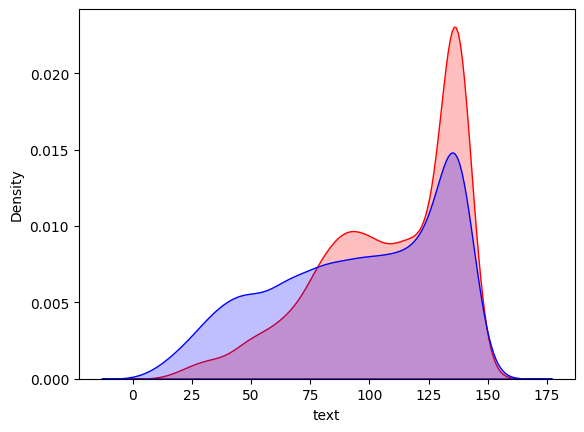

In [7]:
sns.kdeplot(df_train[df_train['target'] == 1]['text'].str.len(), fill=True, color='red')
sns.kdeplot(df_train[df_train['target'] == 0]['text'].str.len(), fill=True, color= 'blue')

In [8]:
fig = px.density_heatmap(df_train, x='target', y='char_count')
fig.update_layout( title='label, char_count density heatmap', 
                   xaxis = dict( showgrid=True, 
                                 rangeslider = dict( visible=True, thickness=0.05 )
                                ), 
                   yaxis = dict( showgrid=True), 
                   legend = dict( orientation='v' ),
                   paper_bgcolor='#FFFFFF')
fig.show(renderer="iframe")

In [9]:
fig = px.bar(df_train, x='target', y='token_count', color='target')
fig.update_layout( title='target, token_count bar chart', 
                   xaxis = dict( showgrid=True, 
                                 rangeslider = dict( visible=True, thickness=0.05 )
                                ), 
                   yaxis = dict( showgrid=True), 
                   legend = dict( orientation='v' ),
                   barmode='overlay', 
                   paper_bgcolor='#FFFFFF')
fig.show(renderer="iframe")

# Preprocessing

In [10]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

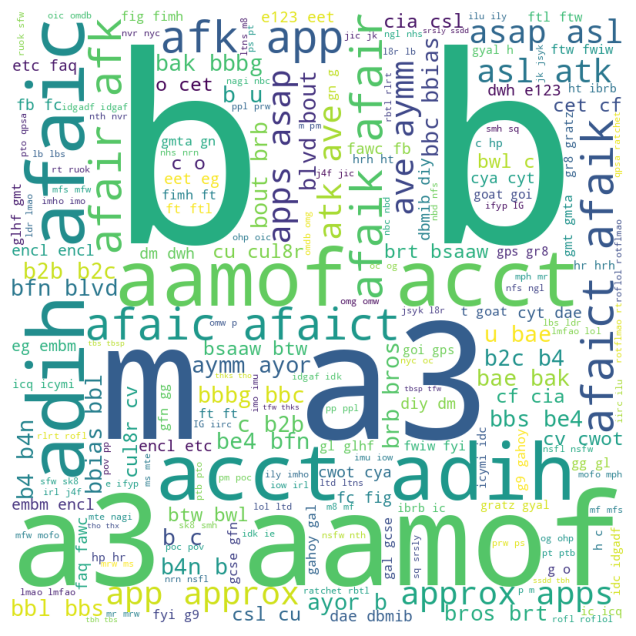

In [11]:
token = list(abbreviations.keys())
comment_words = ''
stopWords = set(STOPWORDS)


for i in range(len(token)):
    token[i] = token[i].lower()
      
    comment_words += " ".join(token)+" "
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopWords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
  
plt.show()

# Cleaning

In [12]:
space = re.compile('[/(){}\[\]\|@,;]')
symbols= re.compile('[^0-9a-z #+_]')

In [13]:
def work_abbr(word):
    if word.lower() in abbreviations.keys():
        return abbreviations[word.lower()]
    else: 
        return word

In [14]:
def sentence_clean(sentence):
    
    sentence = sentence.lower()
    #replace unwanted symbols
    sentence = space.sub(' ', sentence)
    sentence = symbols.sub('', sentence) 
    sentence = sentence.replace('x', '')
        
    #clean the senteces from abbreviations and filling words
    clean_sentence = " "
    for word in sentence.split():
        clean_word = work_abbr(word)
        
        if clean_word not in STOPWORDS:
            clean_sentence += clean_word + " "
        
    return clean_sentence

In [15]:
df_train['clean_text'] = df_train['text'].apply(sentence_clean)

In [16]:
df_train.head()

,text,target,char_count,token_count,clean_text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,13,deeds reason #earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,1,38,7,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1,133,22,residents asked shelter place notified officers evacuation shelter place orders epected
3,"13,000 people receive #wildfires evacuation orders in California",1,65,9,13 000 people receive #wildfires evacuation orders california
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,17,got sent photo ruby #alaska smoke #wildfires pours school


# Building Model

In [17]:
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

2023-01-03 20:26:09.127755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-03 20:26:10.157582: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-03 20:26:10.157632: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-03 20:26:12.874839: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [18]:
lb = LabelBinarizer().fit(list(set(df_train['target'].tolist())))
sentences = df_train["clean_text"].tolist()

In [19]:
embed_matrix = []
for sent in sentences:
    embed_matrix.append(np.array(embed([sent])[0]).tolist())

In [20]:
X, Y = np.array(embed_matrix), lb.transform(df_train['target'].tolist())

# Artificial neural networks model

In [21]:
train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size = 0.15, shuffle=True, random_state=48)

In [22]:
#create the model
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=512))
model.add(tf.keras.layers.Dense(units=256, activation='relu',  kernel_regularizer='l2'))
model.add(tf.keras.layers.Dropout(rate = 0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=128, activation='relu',  kernel_regularizer='l2'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=64, activation='relu',  kernel_regularizer='l2'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=32, activation='relu',  kernel_regularizer='l2'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

#add metrics calculations
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics =['accuracy']) 
#callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [23]:
model.fit(train_x , train_y, epochs=30, batch_size=10, validation_split=0.3, shuffle=False, callbacks=[callback])

Epoch 1/30
453/453 [==============================] - 7s 8ms/step - loss: 4.8421 - accuracy: 0.6394 - val_loss: 3.0353 - val_accuracy: 0.7698
Epoch 2/30
453/453 [==============================] - 4s 8ms/step - loss: 2.1020 - accuracy: 0.7646 - val_loss: 1.3896 - val_accuracy: 0.7884
Epoch 3/30
453/453 [==============================] - 3s 7ms/step - loss: 1.1305 - accuracy: 0.7697 - val_loss: 0.8492 - val_accuracy: 0.7992
Epoch 4/30
453/453 [==============================] - 4s 8ms/step - loss: 0.7988 - accuracy: 0.7766 - val_loss: 0.6708 - val_accuracy: 0.7945
Epoch 5/30
453/453 [==============================] - 4s 9ms/step - loss: 0.6940 - accuracy: 0.7754 - val_loss: 0.6244 - val_accuracy: 0.7935
Epoch 6/30
453/453 [==============================] - 4s 8ms/step - loss: 0.6644 - accuracy: 0.7710 - val_loss: 0.6162 - val_accuracy: 0.7909
Epoch 7/30
453/453 [==============================] - 4s 9ms/step - loss: 0.6646 - accuracy: 0.7721 - val_loss: 0.5957 - val_accuracy: 0.8007
Epoch 

## Model visualization

In [24]:
import visualkeras

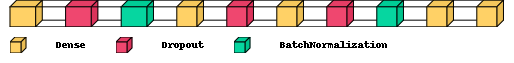

In [25]:
visualkeras.layered_view(model,
                         legend = True, 
                         draw_volume = True, 
                         spacing = 30)

## Result and Evaluation

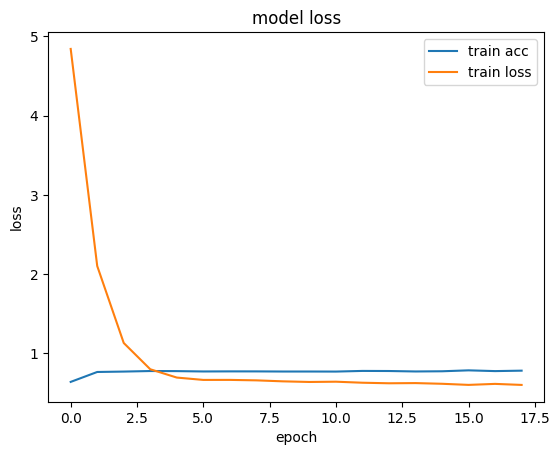

In [26]:
history = model.history
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train acc', 'train loss'], loc='upper right')
plt.show()

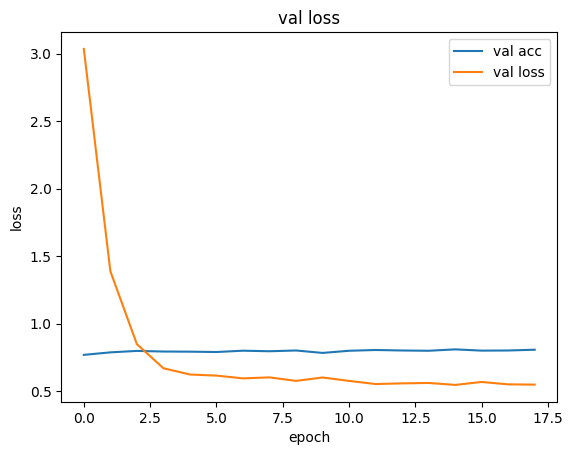

In [27]:
history = model.history
# summarize history for accuracy
plt.plot(history.history['val_accuracy'])
plt.title('val accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# summarize history for loss
plt.plot(history.history['val_loss'])
plt.title('val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val acc', 'val loss'], loc='upper right')
plt.show()

## Predicting on the validation dataset 

In [28]:
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score,accuracy_score
from sklearn.metrics import classification_report

In [29]:
pred = model.predict(val_x)

for threshold in [0.5,0.55,0.6,0.65,0.7,0.75]:
    predicted  = pred > threshold
    print (threshold, 
           round(accuracy_score(val_y, predicted)*100),
           round(recall_score(val_y, predicted, average='macro')*100))

36/36 [==============================] - 0s 3ms/step
0.5 81 80
0.55 81 80
0.6 81 79
0.65 80 79
0.7 79 77
0.75 79 76


In [30]:
val_pred  = pred > 0.55

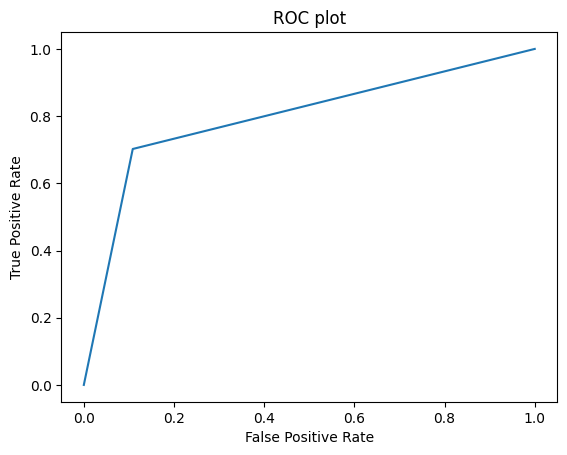

In [31]:
fpr, tpr, _ = roc_curve(val_y, val_pred , pos_label=1)
plt.plot(fpr,tpr)
plt.title("ROC plot")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Confusion Matrix

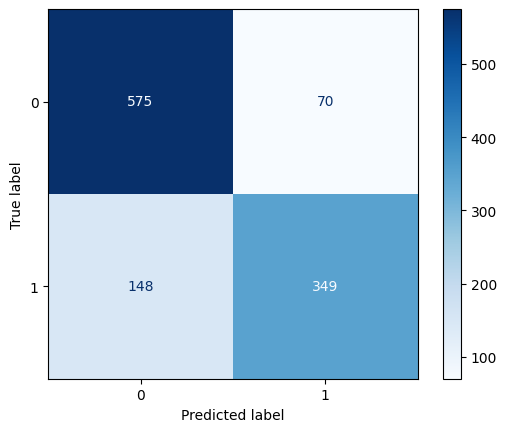

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       645
           1       0.83      0.70      0.76       497

    accuracy                           0.81      1142
   macro avg       0.81      0.80      0.80      1142
weighted avg       0.81      0.81      0.81      1142



In [32]:
cm_rm_2 = confusion_matrix(val_y, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rm_2)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print(classification_report(val_y, val_pred))

In [33]:
f"Score is :{round(accuracy_score(val_y, val_pred)*100)}%"

'Score is :81%'

# Machine Learning model

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

tokenizer = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_train['text'].values)
word_index = tokenizer.word_index
print('In Training data Found %s unique tokens.' % len(word_index))

In Training data Found 23060 unique tokens.


In [35]:
X_lstm = tokenizer.texts_to_sequences(df_train['text'].values)
X_lstm = pad_sequences(X_lstm, maxlen=3000)

In [36]:
X_train_lstm, X_val_lstm, Y_train_lstm, Y_val_lstm = train_test_split(X_lstm,Y, test_size = 0.1, random_state = 42)
print(X_train_lstm.shape,Y_train_lstm.shape)
print(X_val_lstm.shape,Y_val_lstm.shape)

(6851, 3000) (6851, 1)
(762, 3000) (762, 1)


In [37]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=50)

xgb.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

# Results

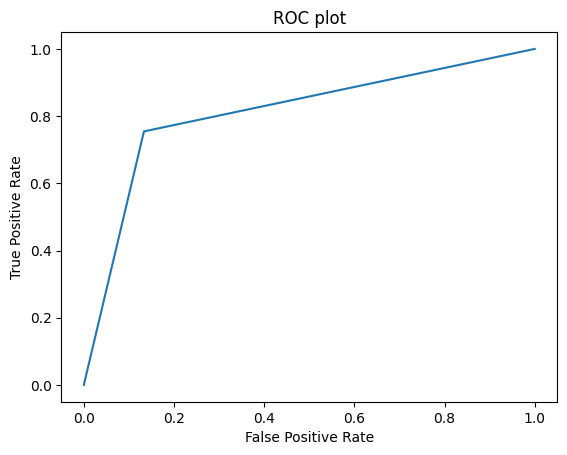

In [40]:
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
fpr, tpr, _ = roc_curve(val_y, xgb.predict(val_x) , pos_label=1)
plt.plot(fpr,tpr)
plt.title("ROC plot")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

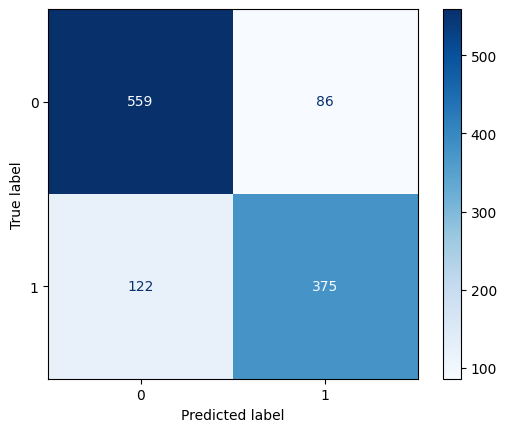

In [41]:
cm_rm_2 = confusion_matrix(val_y, xgb.predict(val_x))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rm_2)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [45]:
print(f"Accuracy Score is :{round(accuracy_score(val_y, xgb.predict(val_x))*100)}%")
print("")
print(classification_report(val_y, xgb.predict(val_x)))

Accuracy Score is :82%

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       645
           1       0.81      0.75      0.78       497

    accuracy                           0.82      1142
   macro avg       0.82      0.81      0.81      1142
weighted avg       0.82      0.82      0.82      1142

